In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [2]:
online = pd.read_csv('chapter_1/online.csv', index_col = 0)
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom
482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom
263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom
495549,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23 15:53:00,2.10,17290,United Kingdom
204384,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25 13:36:00,5.95,17663,United Kingdom


### Read the Dataset

In [3]:
online.shape

(70864, 8)

In [4]:
online.InvoiceNo.nunique()

13858

We have repeated Invoice No, meaning that we have the same purchase in several rows.

In [5]:
online.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70864 entries, 416792 to 312243
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    70864 non-null  int64  
 1   StockCode    70864 non-null  object 
 2   Description  70864 non-null  object 
 3   Quantity     70864 non-null  int64  
 4   InvoiceDate  70864 non-null  object 
 5   UnitPrice    70864 non-null  float64
 6   CustomerID   70864 non-null  int64  
 7   Country      70864 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 4.9+ MB


### Cohort Analysis

In [6]:
#First thing to do is passing our date from object to datetime
online.InvoiceDate = pd.to_datetime(online.InvoiceDate)

In [7]:
def get_day(column): return dt.datetime(column.year, column.month, 1)

#Subset to only the day
online['InvoiceDay'] = online.InvoiceDate.apply(get_day)

#Get the date of first purchase
online['CohortMonth'] = online.groupby('CustomerID')['InvoiceDay'].transform('min')

online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,CohortMonth
416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom,2011-10-01,2011-04-01
482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom,2011-11-01,2011-09-01
263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom,2011-07-01,2011-07-01
495549,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23 15:53:00,2.10,17290,United Kingdom,2011-11-01,2011-11-01
204384,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25 13:36:00,5.95,17663,United Kingdom,2011-05-01,2011-02-01


We will now calculate the difference between the invoice and first purchase in months to find the cohort of the several clients.

In [8]:
def get_dates(df, column): 
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day 
    return year,month, day

#get the individual date parts
invoice_year, invoice_month, invoice_day = get_dates(online, 'InvoiceDate')

#get the individual date parts
cohort_year, cohort_month, cohort_day = get_dates(online, 'CohortMonth')

#get the difference in years
year_diff = invoice_year - cohort_year

#get the difference in months
month_diff = invoice_month - cohort_month

#assign to a new column
online['cohort_index'] = year_diff * 12 + month_diff * 1

online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,CohortMonth,cohort_index
416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom,2011-10-01,2011-04-01,6
482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom,2011-11-01,2011-09-01,2
263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom,2011-07-01,2011-07-01,0
495549,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23 15:53:00,2.10,17290,United Kingdom,2011-11-01,2011-11-01,0
204384,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25 13:36:00,5.95,17663,United Kingdom,2011-05-01,2011-02-01,3


#### 1.Calculate active customers

Firs we will group by per CohortMonth and CohortIndex, then we will count the unique customers that survived during the sequent months.

Pivot the table consequently.

In [9]:
groups = online.groupby(['CohortMonth', 'cohort_index'])['CustomerID'].nunique()
groups = groups.reset_index()
cohort_counts = groups.pivot(index = 'CohortMonth', columns = 'cohort_index', values = 'CustomerID')

In [10]:
cohort_counts.index

DatetimeIndex(['2010-12-01', '2011-01-01', '2011-02-01', '2011-03-01',
               '2011-04-01', '2011-05-01', '2011-06-01', '2011-07-01',
               '2011-08-01', '2011-09-01', '2011-10-01', '2011-11-01',
               '2011-12-01'],
              dtype='datetime64[ns]', name='CohortMonth', freq=None)

#### 2.Retention Rate

In [11]:
#Let's calculaate the total new clients per month (first column)
cohort_sizes = cohort_counts.iloc[:,0]

#Calculate retention
retention = np.round(cohort_counts.divide(cohort_sizes, axis = 0) * 100,2)

retention

cohort_index,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0,34.36,30.87,35.06,34.22,39.80,34.78,32.96,33.52,37.01,35.47,48.60,24.02
2011-01-01,100.0,20.78,24.70,24.40,33.13,27.11,24.70,25.90,31.33,30.72,37.35,13.55,NaN
2011-02-01,100.0,18.35,18.04,26.27,26.90,23.42,25.32,26.27,27.22,30.06,8.86,NaN,NaN
2011-03-01,100.0,16.24,25.77,19.59,21.39,17.27,25.26,21.91,27.58,9.79,NaN,NaN,NaN
2011-04-01,100.0,19.22,20.39,19.22,18.43,20.39,21.96,23.14,6.67,NaN,NaN,NaN,NaN
2011-05-01,100.0,16.06,17.27,14.46,20.88,23.29,24.50,8.84,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,15.94,12.56,19.81,23.67,29.95,9.18,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,16.18,17.92,21.97,25.43,9.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,21.58,20.14,25.18,10.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Recency, frequency, monetary (RFM) segmentation

- Recency - days since last customer transaction
- Frequency - number of transactions in the last 12 months
- Monetary Value - total spend in the last 12 months

In [12]:
online['TotalSum'] = online.Quantity * online.UnitPrice
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,CohortMonth,cohort_index,TotalSum
416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom,2011-10-01,2011-04-01,6,12.60
482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom,2011-11-01,2011-09-01,2,1.45
263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom,2011-07-01,2011-07-01,0,22.50
495549,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23 15:53:00,2.10,17290,United Kingdom,2011-11-01,2011-11-01,0,2.10
204384,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25 13:36:00,5.95,17663,United Kingdom,2011-05-01,2011-02-01,3,17.85


We will consider that we will relate the purchases to the day after the maximum day of purchases.

In [13]:
now_snap = max(online.InvoiceDate) + dt.timedelta(days = 1)
now_snap

Timestamp('2011-12-10 12:49:00')

Group the dataset into e new columns, recency, frequency and monetary value.

In [14]:
groupp = online.groupby('CustomerID').agg({'InvoiceDate' : lambda x: (now_snap - x.max()).days,
                                           'InvoiceNo': 'count',
                                           'TotalSum' : 'sum'})
groupp.columns = ['Recency', 'Frequency', 'MonetaryValue']

groupp.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12747,2,27,992.82
12748,1,967,7522.06
12749,4,37,813.45
12820,3,17,268.02
12822,71,9,146.15


### Create segments for RFM

In [25]:
#As lower the recency better we start by the bigger
groupp['R'] = pd.qcut(groupp.Recency, 3, range(3,0,-1))

#Greater the better
groupp['F'] = pd.qcut(groupp.Frequency, 3, range(1,4))
groupp['M'] = pd.qcut(groupp.MonetaryValue, 3, range(1,4))

groupp.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12747,2,27,992.82,3,3,3,433,10
12748,1,967,7522.06,3,3,3,433,10
12749,4,37,813.45,3,3,3,433,10
12820,3,17,268.02,3,3,3,422,8
12822,71,9,146.15,2,2,2,212,5


In [26]:
groupp['R'] = groupp['R'].astype('int')
groupp['F'] = groupp['F'].astype('int')
groupp['M'] = groupp['M'].astype('int')

In [27]:
def rfm_segment(x): return str(x['R']) + str(x['F']) + str(x['M'])

groupp['RFM_Segment'] = groupp.apply(rfm_segment, axis = 1)

groupp['RFM_Score'] = groupp['R'] + groupp['F'] + groupp['M']

groupp.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12747,2,27,992.82,3,3,3,333,9
12748,1,967,7522.06,3,3,3,333,9
12749,4,37,813.45,3,3,3,333,9
12820,3,17,268.02,3,3,3,333,9
12822,71,9,146.15,2,2,2,222,6


In [38]:
def classification(x):
    
        if x['RFM_Score'] >= 7:
            return 'Top'
        elif ((4 < x['RFM_Score']) and (x['RFM_Score'] < 7)):
            return 'Medium'
        else:
            return 'Weak'

groupp['Classification'] = groupp.apply(classification, axis = 1)

groupp.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score,Classification
CustomerID,,,,,,,,,
12747,2,27,992.82,3,3,3,333,9,Top
12748,1,967,7522.06,3,3,3,333,9,Top
12749,4,37,813.45,3,3,3,333,9,Top
12820,3,17,268.02,3,3,3,333,9,Top
12822,71,9,146.15,2,2,2,222,6,Medium


In [40]:
agg_groupp = groupp.groupby('Classification').agg({'Recency' : 'mean',
                                                   'Frequency' : 'mean',
                                                   'MonetaryValue' : ['mean','count']})
agg_groupp.head()

Recency  Frequency MonetaryValue      
                      mean       mean          mean count
Classification                                           
Medium           94.638889   8.534050    163.973496  1116
Top              30.716525  37.810581    765.384161  1531
Weak            186.295066   3.275142     50.818520  1054

### Data Preprocessing for Kmeans

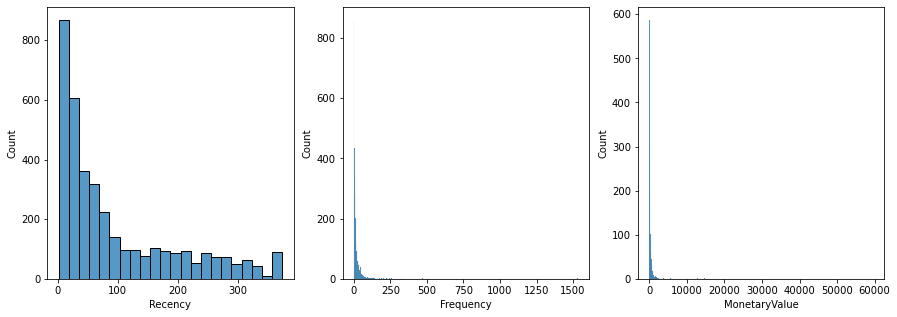

In [76]:
data = groupp[['Recency', 'Frequency', 'MonetaryValue']]
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(data = data, x = 'Recency', ax = ax[0])
sns.histplot(data = data, x = 'Frequency', ax = ax[1])
sns.histplot(data = data, x = 'MonetaryValue', ax = ax[2])
plt.show()

Both the three columns are right skewed, for the application of kmeans the distributions should follow a normal distribution.

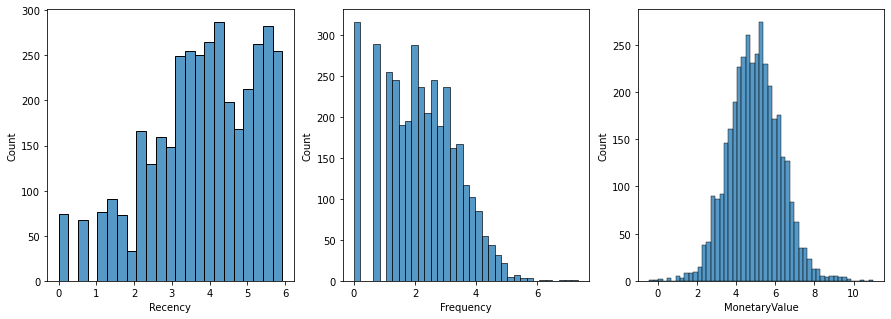

In [77]:
data1 = np.log(data)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(data = data1, x = 'Recency', ax = ax[0])
sns.histplot(data = data1, x = 'Frequency', ax = ax[1])
sns.histplot(data = data1, x = 'MonetaryValue', ax = ax[2])
plt.show()

#### Centering and scaling

In [84]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(data1)
datamart_normalized = scaler.transform(data1)
print('mean: ', data1.mean(axis=0).round(2))
print('std: ', data1.std(axis=0).round(2))

mean:  Recency          3.81
Frequency        2.19
MonetaryValue    4.95
dtype: float64
std:  Recency          1.42
Frequency        1.22
MonetaryValue    1.32
dtype: float64


### Kmeans

In [86]:
# Import package
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=1)

# Compute k-means clustering on pre-processed data
kmeans.fit(datamart_normalized)

# Extract cluster labels from labels_ attribute
cluster_labels = kmeans.labels_

In [87]:
# Create a DataFrame by adding a new cluster label column
datamart_rfm_k3 = data.assign(Cluster=cluster_labels)

# Group the data by cluster
grouped = datamart_rfm_k3.groupby(['Cluster'])

# Calculate average RFM values and segment sizes per cluster value
grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
  }).round(1)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          33.2      35.9         729.8  1675
1         144.8       5.3          91.8  2026

In [89]:
#### Choosing the number of Clusters

sse = {}

# Fit KMeans and calculate SSE for each k
for k in range(2, 15):
  
    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=k, random_state=1)
    
    # Fit KMeans on the normalized dataset
    kmeans.fit(datamart_normalized)
    
    # Assign sum of squared distances to k element of dictionary
    sse[k] = kmeans.inertia_
    
sse

{2: 5858.0763161975665,
 3: 4457.007751144023,
 4: 3715.7622255941856,
 5: 3138.3622570865023,
 6: 2813.9279108729206,
 7: 2540.7065258849866,
 8: 2330.5046168421677,
 9: 2185.0400593776444,
 10: 2040.7580361844284,
 11: 1907.731677853202,
 12: 1780.3709156939371,
 13: 1702.981570448724,
 14: 1629.1100539413733}

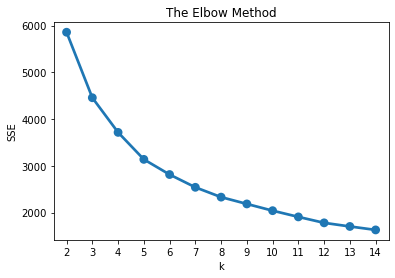

In [90]:
# Add the plot title "The Elbow Method"
plt.title('The Elbow Method')

# Add X-axis label "k"
plt.xlabel('k')

# Add Y-axis label "SSE"
plt.ylabel('SSE')

# Plot SSE values for each key in the dictionary
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

### Calculate relative importance of each attribute

In [91]:
# Calculate average RFM values for each cluster
cluster_avg = datamart_rfm_k3.groupby(['Cluster']).mean() 

# Calculate average RFM values for the total customer population
population_avg = data.mean()

# Calculate relative importance of cluster's attribute value compared to population
relative_imp = cluster_avg / population_avg - 1

# Print relative importance scores rounded to 2 decimals
print(relative_imp.round(2))

         Recency  Frequency  MonetaryValue
Cluster                                   
0          -0.65       0.87           0.92
1           0.54      -0.72          -0.76


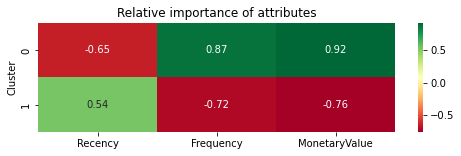

In [92]:
# Initialize a plot with a figure size of 8 by 2 inches 
plt.figure(figsize=(8, 2))

# Add the plot title
plt.title('Relative importance of attributes')

# Plot the heatmap
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()